# Non-Negative Matrix Factorization (NMF)

Some notes I've discovered during my search for Instagram user distance.

Visualisations based on https://www.de.dariah.eu/tatom/topic_model_python.html#using-non-negative-matrix-factorization.


In [1]:
import psycopg2
import psycopg2.extras

import psycopg2.extensions
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

conn = psycopg2.connect("dbname=instagram")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text, username FROM media")
data = cur.fetchall()
media = list(map(lambda i: i[0], data))
usernames = list(map(lambda i: i[1], data))

In [2]:
import numpy as np # a conventional alias

import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='ascii', stop_words='english', min_df=20)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

In [3]:
from sklearn import decomposition

num_topics = 10

num_top_words = 5

clf = decomposition.NMF(n_components=num_topics, random_state=1)

doctopic = clf.fit_transform(dtm)

In [4]:
# print words associated with topics
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
topic_words

[['vscocze', 'vscocam', 'vsco', 'igerscz', 'iglifecz'],
 ['na', 'se', 'je', 'jsem', 'si'],
 ['iglifecz', 'igerscz', 'igraczech', 'travel', 'nature'],
 ['czech', 'inspiration', 'igerscz', 'livefolk', 'czechrepublic'],
 ['love', 'happy', 'today', 'day', 'prague'],
 ['liveauthentic', 'livefolk', 'vsco', 'instagram', 'nature'],
 ['igers', 'vsco', 'instagood', 'vscogood', 'photooftheday'],
 ['lifeofadventure', 'check', 'follow', 'great', 'team'],
 ['czech', 'czechgirl', 'slovakia', 'igerscz', 'czechrepublic'],
 ['vscocam', 'vsco', 'prague', 'instadaily', 'coffee']]

In [5]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [6]:
# turn usernames into an array so we can use NumPy functions
usernames = np.asarray(usernames)

doctopic_orig = doctopic.copy()

# use method described in preprocessing section
num_groups = len(set(usernames))

doctopic_grouped = np.zeros((num_groups, num_topics))

for i, name in enumerate(sorted(set(usernames))):
    doctopic_grouped[i, :] = np.mean(doctopic[usernames == name, :], axis=0)

doctopic = doctopic_grouped

In [7]:
novels = sorted(set(usernames))

print("Top NMF topics in...")

for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(novels[i], top_topics_str))


Top NMF topics in...
_dzejny: 1 4 9
_zebramade: 4 7 9
abdoc: 4 1 7
abtris: 4 1 3
aclotheshorse: 4 5 7
adam.marcan: 4 7 3
adrinellaina: 1 8 5
agebrian: 1 4 8
aguynamedpatrick: 4 7 5
alesroubicek: 1 4 7
alexandrapotsch: 1 4 8
an_yochim: 4 1 3
anastasiaa_straw: 6 4 1
anduiyn: 9 6 4
anetaanie: 2 9 0
angelynpeh: 9 4 7
annabrezinova: 9 2 0
annafromczech: 6 5 0
annamariehradecka: 4 1 9
annaningerova: 2 9 0
annavratilova: 0 5 6
ansvarcova: 1 4 5
axel_from_nord: 1 5 8
baralousova: 2 0 9
bararipnak: 1 4 0
barbora_pavlouskova: 1 4 3
barunnek: 1 8 4
baruozy: 8 4 1
barus14: 4 1 6
beenyjam: 4 3 7
birdieboheme: 4 7 9
bjelah: 4 5 1
blairz: 4 5 7
blondatino: 6 4 9
blossomandbuttercups: 4 7 9
bobmarvan: 1 2 4
bomber38: 1 8 0
bonnieandkleid: 4 6 2
bosch: 4 7 1
bry.raw: 4 3 6
butchwaxvintage: 4 7 5
cam_damage: 4 7 5
cameron.cavanagh: 4 7 9
capturednina: 4 7 2
carekettu: 4 7 2
ceap: 1 4 3
charlotte_something: 4 7 1
chrysseis: 2 4 3
clairehalstead: 4 6 0
clarkatravels: 2 9 4
claudio.x: 4 7 6
copywriterka: 1

In [8]:
N, K = doctopic.shape

%matplotlib inline
import matplotlib.pyplot as plt

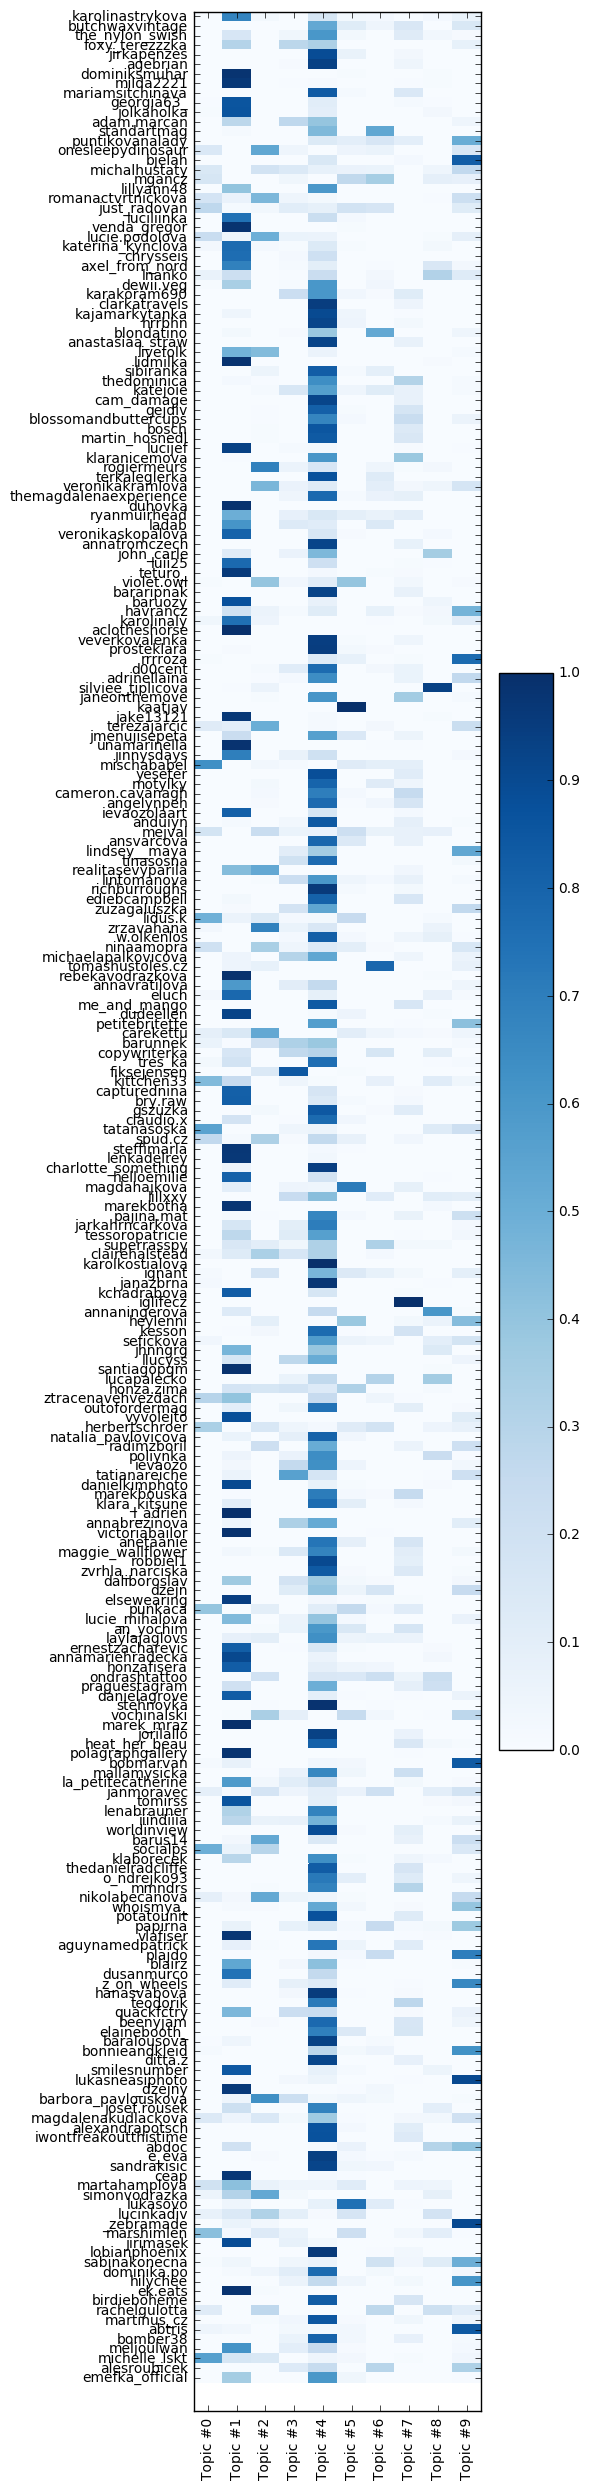

In [9]:
plt.figure(figsize=(6, 25))  # use a bigger canvas than usual

plt.pcolor(doctopic, norm=None, cmap='Blues')

topic_labels = ['Topic #{}'.format(k) for k in range(K)]

# put the major ticks at the middle of each cell
# the trailing semicolon ';' suppresses output
plt.yticks(np.arange(doctopic.shape[0])+0.5, usernames);

plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')

plt.tight_layout()  # fixes margins

plt.show()